In [198]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import NullLocator

import time
from numba import jit

In [119]:
def get_eig(images):
    corr = images@images.T/len(images[0,:])
    eig_val = np.linalg.svd(corr, hermitian=True, compute_uv=False)
    return eig_val

def get_U_eig(images):
    corr = images@images.T/len(images[0,:])
    U, eig_val, V = np.linalg.svd(corr, hermitian=True)
    return U, eig_val

def get_linear(x, y, yllim):
    n = len(x)

    x_fit = np.zeros(n)
    y_fit = np.zeros(n)
    count = 0

    for i in range(n):
        if y[i] > yllim:
            x_fit[count] = np.log10(x[i]+1)
            y_fit[count] = np.log10(y[i])
            count += 1
                
    model = LinearRegression()
    model.fit(x_fit[:count].reshape(-1, 1), y_fit[:count])
    
    return model.coef_, model.intercept_

def optimize_parameters(x, y, func, initial_params):
    """
    x座標、y座標、および関数に基づいてパラメータを最適化する関数。

    Args:
        x (array-like): x座標のデータ
        y (array-like): y座標のデータ（観測値）
        func (callable): パラメータを含む関数 func(x, *params)
        initial_params (array-like): パラメータの初期値

    Returns:
        result (OptimizeResult): scipy.optimize.minimizeの結果オブジェクト
    """
    # 二乗和誤差を計算する目的関数
    def sse(params):
        y_pred = func(x, *params)
        return np.sum((y - y_pred) ** 2)
    
    # scipy.optimize.minimizeで最適化
    result = minimize(sse, initial_params)
    return result

def power_exp(x, a, b, c):
    return -a * x - b*np.exp(x) + c
def power(x, a, c):
    return -a * x + c

In [54]:
# @jit('Tuple((f8,f8))(i8, f8[:,:], f8, i8)',nopython=True)
# def time_dev_ava(N, J, theta, iter_max):
#     x_mat = np.zeros((N,iter_max))
#     x_mat[0,0] = 1
#     size = 0
#     duration = 0
#     for t in range(iter_max-1):
#         for i in range(N):
#             temp = 0
#             for j in range(N):
#                 temp += J[i,j]*x_mat[j,t]
#             x_mat[i,t+1] = temp > theta
            
#         if np.sum(x_mat[:,t+1]) == 0:
#             size = np.sum(x_mat)
#             duration = t+1
#             break
    
#     return size, duration

# @jit('f8[:](i8, f8[:,:], f8, i8)',nopython=True)
# def get_ava_list(N, J, theta, iter_max):
#     ava_list = np.ones(N)
#     for i in range(N):
#         x = np.zeros(N)
#         x[i] = 1
#         for t in range(iter_max-1):
#             for j in range(N):
#                 temp = 0
#                 for k in range(N):
#                     temp += J[j,k]*x[k]
#                 if temp > theta:
#                     x[j] = 1
#                     ava_list[i] += 1
#                 else:
#                     x[j] = 0
#             if np.sum(x) == 0:
#                 break
#     return ava_list

# def get_ava_list2(N, J, theta, iter_max):
#     ava_list = np.ones(N)
#     for i in range(N):
#         x = np.zeros(N)
#         x[i] = 1
#         for t in range(iter_max-1):
#             x = np.dot(J,x) > theta
#             ava_list[i] += np.sum(x)
#             if np.sum(x) == 0:
#                 break
#     return ava_list

def get_ava(N, J, theta, iter_max):
    size_arr = np.ones(N)
    duration_arr = np.zeros(N)
    for i in range(N):
        x = np.zeros(N)
        x[i] = 1
        for t in range(iter_max-1):
            x = np.dot(J,x) > theta
            size_arr[i] += np.sum(x)
            duration_arr[i] += 1
            if np.sum(x) == 0:
                break
    return size_arr.astype(int), duration_arr.astype(int)

In [33]:
@jit('Tuple((f8[:,:],i8))(i8, f8[:,:], f8, i8, i8, b1[:,:])',nopython=True)
def time_dev_raster(N, J, theta, iteration, spike_max, rand_fire):
    x_mat = np.zeros((N,iteration))
    x_mat[0,0] = 1
    
    raster = np.zeros((2,spike_max))
    spike_count = 0
    for t in range(iteration-1):
        for i in range(N):
            temp = 0
            for j in range(N):
                temp += J[i,j]*x_mat[j,t]
            x_mat[i,t+1] = (temp > theta) or (rand_fire[i,t])
            if x_mat[i,t+1] > 0 and spike_count < spike_max:
                raster[0,spike_count] = i
                raster[1,spike_count] = t+1
                spike_count += 1
                
    return raster, spike_count

@jit('f8[:,:](i8, f8[:,:], f8, i8, i8, b1[:,:])',nopython=True)
def time_dev_meanzero_images(N, J, theta, iteration, bin, rand_fire):
    x_mat = np.zeros((N,iteration))
    x_mat[:N//2,0] = 1

    for t in range(iteration-1):
        for i in range(N):
            temp = 0
            for j in range(N):
                temp += J[i,j]*x_mat[j,t]
            x_mat[i,t+1] = (temp > theta) or (rand_fire[i,t])
    
    y_mat = np.zeros((N,iteration//bin))
    for s in range(iteration//bin-1):
        y_mat[:,s] = np.sum(x_mat[:,s*bin:(s+1)*bin],axis=1)
    for i in range(N):
        y_mat[i,:] -= np.mean(y_mat[i,:])
                
    return y_mat

def time_dev_meanzero_images2(N, J, theta, iteration, bin, rand_fire):
    x_mat = np.zeros((N,iteration))
    x_mat[:N//2,0] = 1

    for t in range(iteration-1):
        x_mat[:,t+1] = np.logical_or(np.dot(J,x_mat[:,t]) > theta, rand_fire[:,t])
    
    y_mat = np.zeros((N,iteration//bin))
    for s in range(iteration//bin-1):
        y_mat[:,s] = np.sum(x_mat[:,s*bin:(s+1)*bin],axis=1)
    
    y_mat -= np.mean(y_mat, axis=1, keepdims=True)
                
    return y_mat

def time_dev_meanzero_images3(N, J, theta, iteration, bin, rand_fire):
    x_mat = np.zeros((N,bin))
    x_mat[:N//2,0] = 1
    y_mat = np.zeros((N,iteration//bin))
    
    for s in range(iteration//bin):
        for t in range(bin):
            x_mat[:,(t+1)%bin] = np.logical_or(np.dot(J,x_mat[:,t]) > theta, rand_fire[:,t+bin*s])
        y_mat[:,s] = np.sum(x_mat,axis=1)
    
    y_mat -= np.mean(y_mat, axis=1, keepdims=True)
                
    return y_mat

## 連続時間バージョン
@jit('f8[:,:](i8, f8[:,:], f8, i8, f8[:])',nopython=True)
def time_dev_con(N, J, dt, iteration, x_start):
    x_mat = np.zeros((N,iteration))
    x_mat[:,0] = x_start

    for t in range(iteration-1):
        for i in range(N):
            temp = 0
            for j in range(N):
                temp += J[i,j]*x_mat[j,t]
            x_mat[i,t+1] = x_mat[i,t] +dt*(-x_mat[i,t]+temp)
                
    return x_mat

def get_firingrate(raster,N):
    frate = np.zeros(N)
    for i in range(len(raster[0,:])):
        frate[int(raster[0,i])] += 1
    return frate/raster[1,-1]

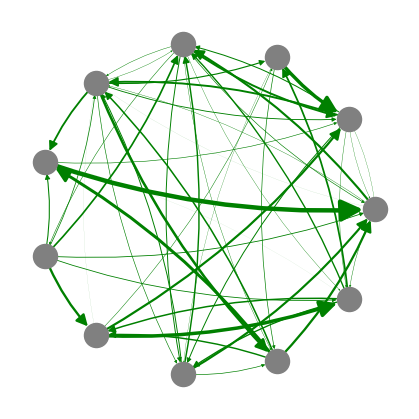

In [290]:
# 1. ノード数
num_nodes = 11

# 2. コーシー分布から重みを生成（位置=0、スケール=1）
def sample_gauss(size):
    return np.random.normal(size=size)*(np.random.rand(size)>0.5)

# 3. 有向グラフを作成（全結合の有向グラフ）
G = nx.DiGraph()

# 4. ノードを追加
G.add_nodes_from(range(num_nodes))

# 5. 有向エッジを追加（自己結合は除外）
for u in range(num_nodes):
    for v in range(num_nodes):
        if u != v:  # 自己結合を除外
            G.add_edge(u, v, weight=sample_gauss(1)[0])  # 重みをコーシー分布からサンプリング


# 5. エッジの重みを取得して太さに反映
edge_weights = [abs(G[u][v]['weight']) for u, v in G.edges() if u != v]
arrowsize = [weight * 10 for weight in edge_weights]  # エッジの太さに基づいて矢印のサイズをスケーリング

# 6. 可視化
plt.figure(figsize=(4, 4))

pos = nx.circular_layout(G)
nx.draw(
    G,
    pos,
    with_labels=False,
    node_color='gray',
    node_size=300,
    font_size=10,
    connectionstyle='arc3,rad=0.1',  # エッジを曲線で描画
    edge_color='g',
    width=3*edge_weights,  # エッジの太さを重みに基づいて設定
    arrowsize=arrowsize  # エッジの重みに基づいて矢印サイズを調整
)
# plt.show()
plt.savefig('/Users/nakamuta/Documents/VSCode/PowerLawCoding/241122/Fig4A.eps', transparent=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


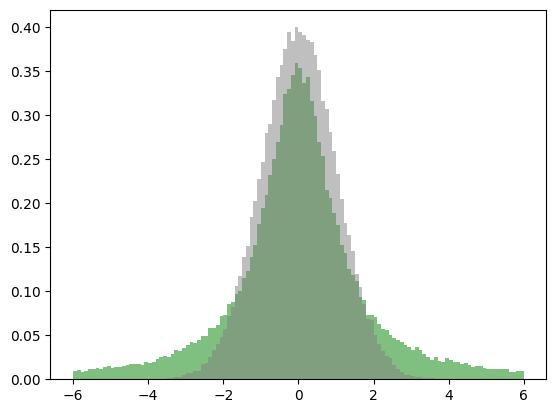

In [285]:
K = 100000
J_cauchy = np.random.standard_cauchy(size=K)
J_gauss = np.random.normal(size=K)

bin_edges = np.arange(-6, 6.1, 0.1)
plt.hist(J_cauchy, bins = bin_edges, alpha=0.5, color="g", density=True)
plt.hist(J_gauss, bins = bin_edges, alpha=0.5, color="gray", density=True)
# plt.show()
plt.savefig(f"Fig4B.eps")

神経雪崩のサイズ分布(豊泉論文に準拠)

In [84]:
N = 100
theta = 0.01
iter_max = int(1e4)
size_max = 100000
dura_max = iter_max
sample_J = 10
g_list = np.array([0.0,0.1])*np.pi
connect_prob = 0.01
connect_type = 'Gauss'

path = '/Users/nakamuta/Documents/VSCode/PowerLawCoding/241122/data/avalanche'

for i_g in range(len(g_list)):
    size_hist = np.zeros(size_max)
    dura_hist = np.zeros(dura_max)
    g = g_list[i_g]
    for sample in range(sample_J):
        print(sample)
        if connect_type == 'Cauchy':
            J = g/N * np.random.standard_cauchy((N,N)) * (np.random.rand(N,N) < connect_prob)
        elif connect_type == 'Gauss':
            J = g/np.sqrt(N) * np.random.normal(size=(N,N)) * (np.random.rand(N,N) < connect_prob)
        else:
            print('Connection type error')
        np.fill_diagonal(J, 0)

        size_arr, dura_arr = get_ava(N, J, theta, iter_max)

        for i in range(N):
            size = size_arr[i]
            dura = dura_arr[i]
            if size < size_max:
                size_hist[size] += 1
            if dura < dura_max:
                dura_hist[dura] += 1
        # for s in range(size_max):
        #     size_hist[s] += np.sum(size_arr == s)
        #     if np.sum(size_arr >= s) == 0:
        #         break
        # for d in range(dura_max):
        #     dura_hist[d] += np.sum(dura_arr == d)
        #     if np.sum(dura_arr >= d) == 0:
        #         break

    size_hist /= np.sum(size_hist)
    dura_hist /= np.sum(dura_hist)
    
    
    np.save(path+f'/{connect_type}/size_hist_{g/np.pi}', size_hist)
    np.save(path+f'/{connect_type}/dura_hist_{g/np.pi}', dura_hist)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)


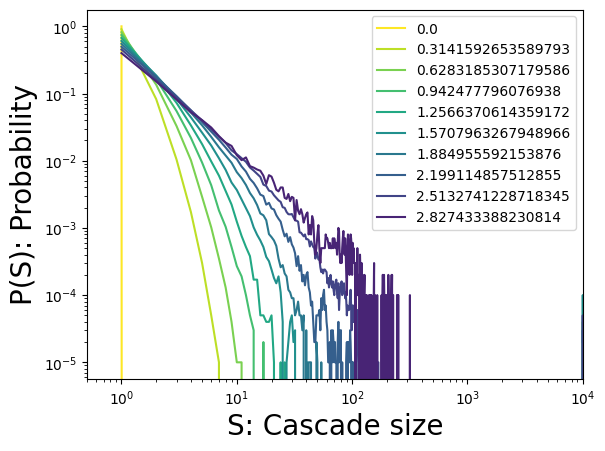

In [113]:
g_list = np.arange(0.,1.0,0.1)*np.pi
connect_type = 'Cauchy'
size_max = 100000
path = '/Users/nakamuta/Documents/VSCode/PowerLawCoding/241122/data/avalanche'

for i_g in range(len(g_list)):
    g = g_list[i_g]
    size_hist = np.load(path+f'/{connect_type}/size_hist_{(g/np.pi):.1f}.npy')
    print(np.shape(size_hist))
    
    plt.plot(np.arange(1,size_max), size_hist[1:], label=g, color=cm.viridis_r(g/np.pi))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S: Cascade size',fontsize=20)
plt.ylabel('P(S): Probability',fontsize=20)
plt.xlim([0.5,1e4])
plt.legend()
plt.show()

In [ ]:
for i_g in range(len(g_list)):
    g = g_list[i_g]
    plt.plot(np.arange(1,size_max), size_hist[i_g,1:]/np.sum(size_hist[i_g,1:]), label=g, color=cm.viridis_r(g/np.pi))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S: Cascade size',fontsize=20)
plt.ylabel('P(S): Probability',fontsize=20)
plt.legend()
# plt.xlim([2.5e5,2.71e5])
# plt.savefig(f"figure4_avalanche_cauchy.eps")
plt.show()

冪則神経活動

In [6]:
N = 1000
theta = 1.
iteration = int(1e4)
bin = 10
rand_fire = np.random.rand(N,iteration) < 1/(10*N)
sample_g = 1
g = np.pi
# g_list = np.arange(0,1.1,0.1)*np.pi

J = g/N * np.random.standard_cauchy((N,N))
y_mat = time_dev_meanzero_images(N, J, theta, iteration, bin, rand_fire)

In [44]:
N = 10000
theta = 0.01
iteration = int(1e5)
bin = 10
iter_g = 1
connect_prob = 0.01
connect_type = 'Gauss'

path = '/Users/nakamuta/Documents/VSCode/PowerLawCoding/241122/data/dimension'

for g in np.arange(0.9,1.1,0.1)*np.pi:
    eigspec_all = np.zeros((iter_g, N))
    for i_g in range(iter_g):
        rand_fire = np.random.rand(N,iteration) < 1/(10*N)
        # J = g/N * np.random.standard_cauchy((N,N)) * (np.random.rand(N,N) < connect_prob)
        J = g/np.sqrt(N) * np.random.normal(size=(N,N)) * (np.random.rand(N,N) < connect_prob)
        np.fill_diagonal(J, 0)

        Y = time_dev_meanzero_images3(N, J, theta, iteration, bin, rand_fire)
        eigspec_all[i_g,:] = get_eig(Y)
    np.save(path+f'/{connect_type}/eigspec_{(g/np.pi):.1f}', eigspec_all)

/var/folders/4j/czkg4fp95bl1q9x9s6jwvf240000gn/T/ipykernel_92597/2845483364.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  gray_cmap = cm.get_cmap("gray_r")


[-1.563033]


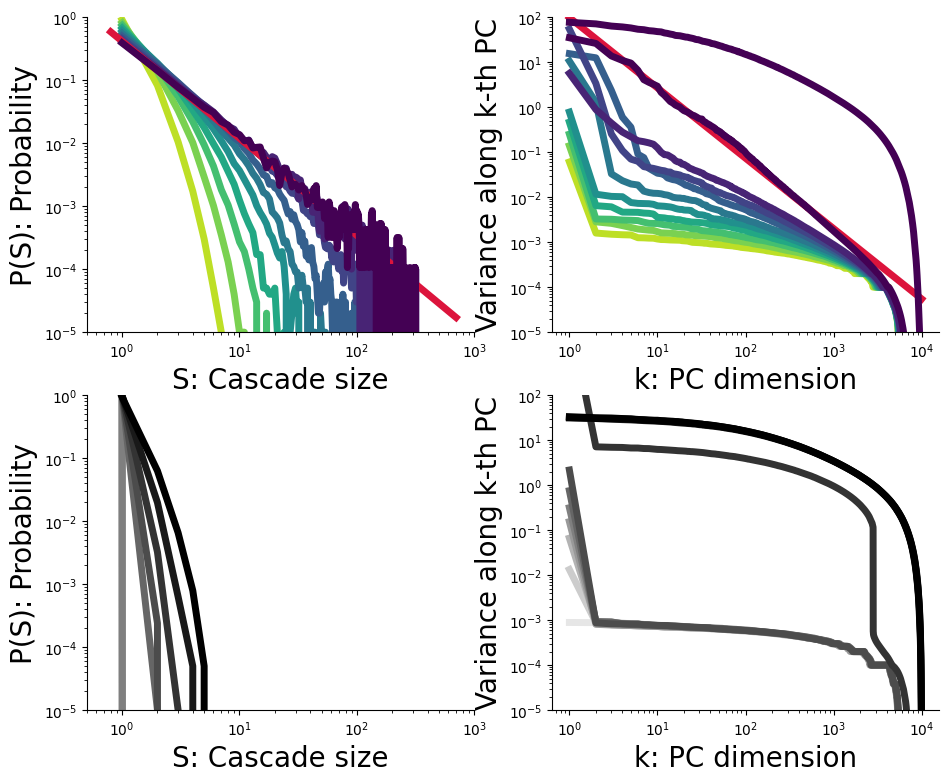

In [298]:
fig, axes = plt.subplots(2,2,figsize=(11,9))
ax1, ax3, ax2, ax4 = axes.flatten()

g_list = np.arange(0.1,1.2,0.1)*np.pi
yllim = -10
path = '/Users/nakamuta/Documents/VSCode/PowerLawCoding/241122/data'

size_max = 100000
gray_cmap = cm.get_cmap("gray_r")

for i_g in range(len(g_list)):
    g = g_list[i_g]
    varspec_cauchy = np.load(path+f'/dimension/Cauchy/eigspec_{(g/np.pi):.1f}.npy')[0]
    varspec_gauss = np.load(path+f'/dimension/Gauss/eigspec_{(g/np.pi):.1f}.npy')[0]
    if g <= np.pi:
        size_hist_cauchy = np.load(path+f'/avalanche/Cauchy/size_hist_{(g/np.pi):.1f}.npy')
        size_hist_gauss = np.load(path+f'/avalanche/Gauss/size_hist_{(g/np.pi):.1f}.npy')
            
        if g == np.pi:
            x_log = 2**np.arange(0,12)
            a,b = get_linear(x_log, varspec_cauchy[x_log], 0)
            x_axis = np.arange(1, N+1, 1)
            print(a)
            ax3.plot(x_axis, 10**(b)*x_axis**a, c='crimson', linewidth=5)
            
            x_log = 2**np.arange(0,7)
            a,b = get_linear(x_log, size_hist_cauchy[x_log+1], 0)
            x_axis = np.arange(0.8, 700, 1)
            ax1.plot(x_axis, 10**b*x_axis**a, c='crimson', linewidth=5)
            
        ax1.plot(np.arange(1,size_max), size_hist_cauchy[1:], label=g, color=cm.viridis_r(g/np.pi),linewidth=5)
        ax2.plot(np.arange(1,size_max), size_hist_gauss[1:], label=g, color=gray_cmap(g/np.pi),linewidth=5)
        
    
    ax3.plot(np.arange(1,len(varspec_cauchy)+1), varspec_cauchy, label=g, color=cm.viridis_r(g/np.pi),linewidth=5)
    ax4.plot(np.arange(1,len(varspec_gauss)+1), varspec_gauss, label=g, color=gray_cmap(g/np.pi),linewidth=5)


for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for ax in [ax1,ax2]:
    ax.set_xlabel('S: Cascade size',fontsize=20)
    ax.set_ylabel('P(S): Probability',fontsize=20)
    ax.set_xlim([0.5,1e3])
    ax.set_ylim([1e-5,1])
    
for ax in [ax3,ax4]:
    ax.set_xlabel('k: PC dimension',fontsize=20)
    ax.set_ylabel('Variance along k-th PC',fontsize=20)
    ax.set_ylim([1e-5,1e2])
    
# plt.show()
plt.savefig("Fig4C.eps", transparent=True)

In [132]:
x_fit = 2**np.arange(1,14) - 1
x_log = np.log10(x_fit+1)
initial_guess = [1.2,0.0,1.0]
yllim = -7

g_list = np.arange(0.1,1.2,0.1)*np.pi
path = '/Users/nakamuta/Documents/VSCode/PowerLawCoding/241122/data/dimension'

Dim_abc_cauchy = np.zeros((len(g_list),3))
Dim_abc_gauss = np.zeros((len(g_list),3))

for i_g in range(len(g_list)):
    g = g_list[i_g]
    varspec = np.load(path+f'/Cauchy/eigspec_{(g/np.pi):.1f}.npy')[0]
    y_log = np.log10(varspec[x_fit])
    result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power_exp, initial_guess)
    a,b,c = result.x
    if b > 0:
        Dim_abc_cauchy[i_g,:] = [a,b,c]
    else:
        result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power, [a,c])
        a,c = result.x
        Dim_abc_cauchy[i_g,:] = [a,0,c]
    
    varspec = np.load(path+f'/Gauss/eigspec_{(g/np.pi):.1f}.npy')[0]
    y_log = np.log10(varspec[x_fit])
    result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power_exp, initial_guess)
    a,b,c = result.x
    if b > 0:
        Dim_abc_gauss[i_g,:] = [a,b,c]
    else:
        result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power, [a,c])
        a,c = result.x
        Dim_abc_gauss[i_g,:] = [a,0,c]

In [136]:
print(Dim_abc_cauchy)

[[ 0.08917154  0.02423057 -2.75532587]
 [ 0.15743766  0.02448599 -2.5048948 ]
 [ 0.12118882  0.03277093 -2.39702536]
 [ 0.19197935  0.03323521 -2.12307683]
 [ 0.28634894  0.03340113 -1.79591315]
 [ 0.93146746  0.         -0.61489761]
 [ 1.26361192  0.          0.39946557]
 [ 1.10928016  0.          0.07003749]
 [ 0.95700582  0.01787189  0.11710337]
 [ 1.37545933  0.0239718   1.87037618]
 [-0.04889767  0.08992949  1.85737041]]


(1000, 10000)
1.1596057447604836e-18 0.2723025217841361


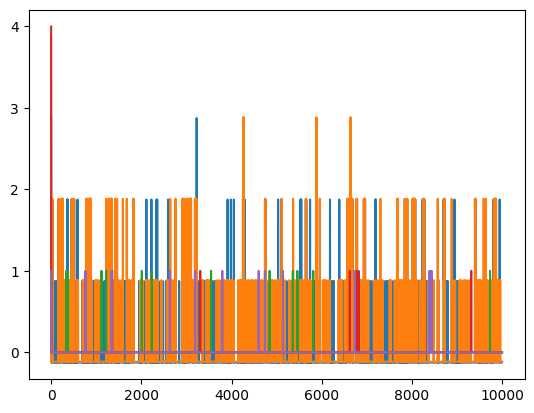

In [95]:
print(np.shape(Y))
print(np.mean(Y),np.std(Y))
for i in range(5):
    plt.plot(Y[i,:])
# plt.imshow(Y[:1000,0:1000]>1.,cmap='gray_r')
plt.show()

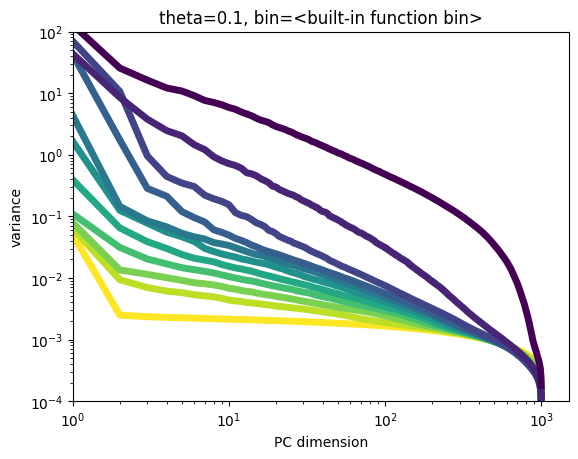

In [18]:
g_list = np.arange(0,1.1,0.1)*np.pi
# g_list = [0.95*np.pi]
x_axis = np.arange(1, N+1, 1)
# plt.plot(x_axis, 10**(b)*x_axis**a, c='crimson', linewidth=5)

path = '/Users/nakamuta/Documents/VSCode/PowerLawCoding/240604/data'
# for s in np.arange(10,-1,-1):
for i in range(len(g_list)):
    g = g_list[i]
    eigspec_all = np.load(path+f'/eigspec_{round(g/np.pi,2)}.npy')
    plt.plot(x_axis,np.mean(eigspec_all,axis=0), color=cm.viridis(1-g/np.pi), linewidth=5)
    
    # plt.errorbar(x_axis,np.mean(eigspec_all,axis=0),np.std(eigspec_all,axis=0), color=cm.viridis(1-g/np.pi))
    # for j in range(iter_g):
    #     plt.plot(x_axis,eigspec_all[j,:], color=cm.viridis(1-g/np.pi))
plt.xscale('log')
plt.yscale('log')
plt.title(f'theta={theta}, bin={bin}')
plt.xlabel('PC dimension')
plt.ylabel('variance')
plt.xlim([1e0,1.5e3])
plt.ylim([1e-4,1e2])
# plt.savefig(f"figure4_power_formation_gauss.eps")
plt.show()

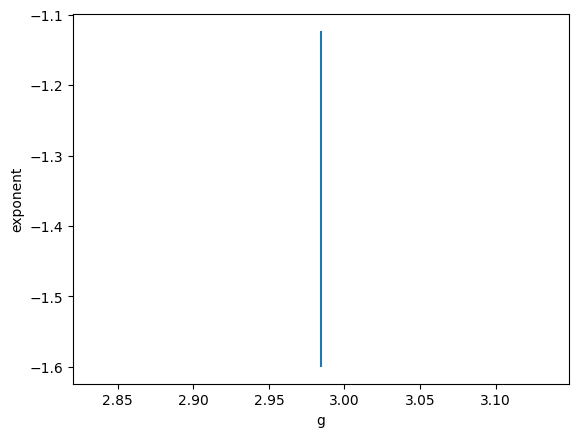

In [71]:
a_all = np.zeros((len(g_list),iter_g))
for i in range(len(g_list)):
    g = g_list[i]
    eigspec_all = np.load(path+f'/eigspec_{round(g/np.pi,1)}.npy')
    for j in range(iter_g):
        a, b = get_linear(eigspec_all[j,:100], 1e-3)
        a_all[i,j] = a
        
plt.errorbar(g_list, np.mean(a_all,axis=1), np.std(a_all,axis=1))
plt.xlabel('g')
plt.ylabel('exponent')
plt.show()

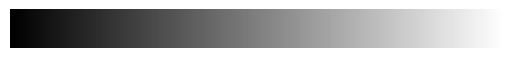

In [297]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots()
ax.imshow(gradient, aspect=10, cmap=plt.cm.gray)
ax.set_axis_off()
plt.savefig(f"Fig4_colorba_grayr.eps")

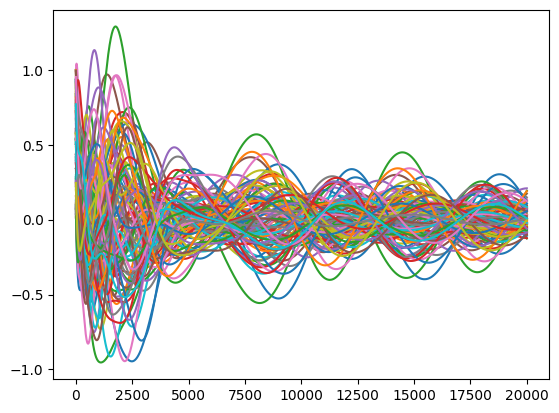

In [63]:
N = 1000
theta = 1.
iteration = int(2e4)
dt = 0.01

J = np.random.normal(0,theta/np.sqrt(N),(N,N))
np.fill_diagonal(J, 0)
x_start = np.random.rand(N)

x_mat = time_dev_con(N, J, dt, iteration, x_start)

for i in range(100):
    plt.plot(x_mat[i,:])
plt.show()

In [22]:
frate = get_firingrate(raster, N)
i_sort_frate = np.argsort(-frate)

(-0.4, 0.4)

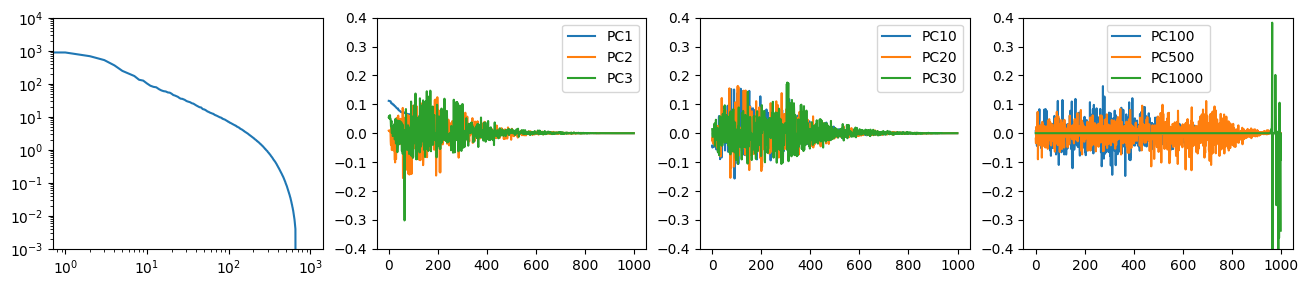

In [33]:
fig = plt.figure(figsize=(16,3))

plt.subplot(1,4,1)
plt.plot(eigspec)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-3,1e4])

plt.subplot(1,4,2)
for i in range(0,3):
    plt.plot(U[i_sort_frate,i], label=f'PC{i+1}')
# plt.ylabel('weight of each PC')
plt.ylim([-0.4,0.4])
plt.legend()

plt.subplot(1,4,3)
for i in [9,19,29]:
    plt.plot(U[i_sort_frate,i], label=f'PC{i+1}')
# plt.ylabel('weight of each PC')
plt.legend()
plt.ylim([-0.4,0.4])

plt.subplot(1,4,4)
for i in [99,499,999]:
    plt.plot(U[i_sort_frate,i], label=f'PC{i+1}')
# plt.ylabel('weight of each PC')
plt.legend()
plt.ylim([-0.4,0.4])

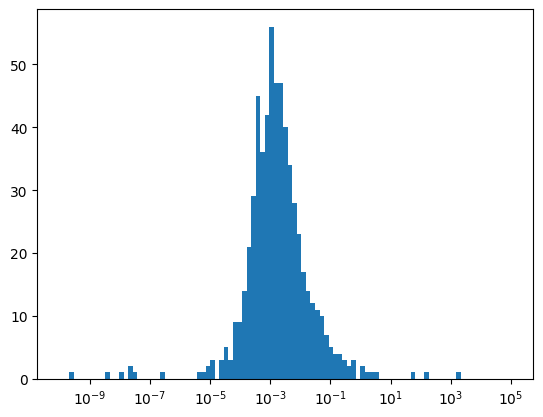

In [24]:
plt.hist(eigspec, bins=np.logspace(-10, 5, 100))
plt.xscale('log')
# plt.yscale('log')
plt.show()

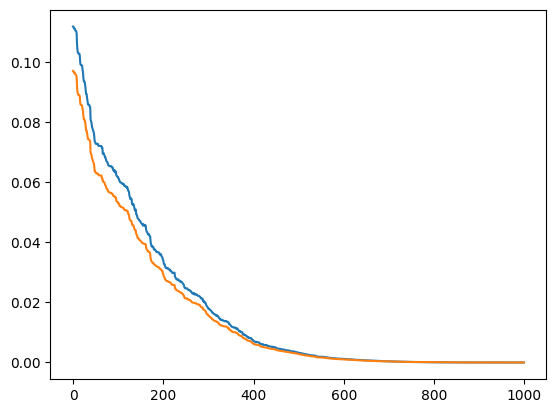

In [35]:
plt.plot(U[i_sort_frate,0], label=f'PC{1}')
plt.plot(0.1*frate[i_sort_frate])

人工データで主成分の空間構造がどうなるかを調べる
発火率を保ってランダムにしたデータなら冪則神経活動は出ないだろう。そのとき空間構造はどうなるか？（全ての主成分が少数の細胞に対応してほしい）
ランダムな発火に全体の同期発火を加えたら冪則神経活動はどうなるだろう。そのとき空間構造はどうなるか？（下位の主成分が多数の細胞に対応するか？）

In [ ]:
def generate_image(N,iteration,dt,rate_indiv_list,rate_whole):
    image = np.zeros((N,iteration))
    aaaa
    return image